# Advanced Reservoir Sensitivity Analysis: Latin Hypercube with Correlation Control
**Author:** Ade Anggi Naluriawan Santoso | **Project:** Reservoir Simulation & History Matching

## 1. Executive Summary
This notebook demonstrates an **expert-level workflow** for generating a Design of Experiments (DoE) for reservoir simulation. 

Standard Latin Hypercube Sampling (LHS) often fails to capture geological realism because it treats parameters as independent. In reality, reservoir properties are coupled (e.g., Porosity and Permeability). This workflow implements the **Iman-Conover Method** (1982) to enforce a specific correlation structure onto the LHS samples without distorting their marginal distributions.

### Workflow Steps
1.  **LHS Generation:** Stratified sampling of the unit hypercube.
2.  **Iman-Conover Correlation:** Re-ordering samples to respect geological dependencies (e.g., $\rho_{\phi,k} = 0.8$).
3.  **Inverse Transformation:** Mapping correlated unit samples to physical distributions (Normal, LogNormal, etc.).
4.  **Mock Simulation:** Running a physics-based proxy equation ($N_p$) to simulate reservoir response.
5.  **Sensitivity Analysis:** generating a Tornado Plot to identify key drivers of production.

---

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import qmc, norm, lognorm, uniform, triang, spearmanr
from scipy.linalg import cholesky
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

# Global Configuration
SEED = 42
N_SAMPLES = 100

# Set plotting style for professional reports
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("talk")

## 2. Define Uncertainty & Correlation Matrix
We define 4 key reservoir parameters. Note that we define a **Correlation Matrix** to enforce the relationship between Porosity and Permeability.

**Parameters:**
1.  **Porosity ($\phi$):** Normal Distribution
2.  **Permeability ($k$):** LogNormal Distribution (Dependent on $\phi$)
3.  **Water Saturation ($S_w$):** Uniform Distribution (Weak negative correlation with $k$)
4.  **Thickness ($h$):** Triangular Distribution (Independent)

In [2]:
# 2.1 Parameter Definitions
params = {
    'Porosity': {'dist': 'normal', 'p1': 0.20, 'p2': 0.03},  # Mean, Std
    'Permeability': {'dist': 'lognormal', 'p1': 50, 'p2': 0.8}, # Median, Sigma (Shape)
    'Water_Sat': {'dist': 'uniform', 'p1': 0.15, 'p2': 0.40}, # Min, Max
    'Thickness': {'dist': 'triangular', 'p1': 50, 'p2': 150}  # Min, Max
}
param_names = list(params.keys())
n_dim = len(param_names)

# 2.2 Target Correlation Matrix (Geological Constraints)
# Order: [Porosity, Permeability, Water_Sat, Thickness]
target_corr = np.array([
    [ 1.0,  0.8, -0.4,  0.0], # Porosity
    [ 0.8,  1.0, -0.6,  0.0], # Permeability (Strong pos with Poro, neg with Sw)
    [-0.4, -0.6,  1.0,  0.0], # Water Sat
    [ 0.0,  0.0,  0.0,  1.0]  # Thickness (Independent)
])

print("Target Correlation Matrix:")
print(pd.DataFrame(target_corr, index=param_names, columns=param_names))

Target Correlation Matrix:
              Porosity  Permeability  Water_Sat  Thickness
Porosity           1.0           0.8       -0.4        0.0
Permeability       0.8           1.0       -0.6        0.0
Water_Sat         -0.4          -0.6        1.0        0.0
Thickness          0.0           0.0        0.0        1.0


## 3. The Engine: Iman-Conover Method
This function is the core of the expert workflow. It takes uncorrelated LHS samples and re-shuffles them to match the target correlation matrix.

In [3]:
def apply_iman_conover(lhs_samples, target_corr):
    """
    Applies Iman-Conover rank re-ordering to enforce correlation.
    
    Args:
        lhs_samples (np.array): (N, D) matrix of uniform samples [0, 1].
        target_corr (np.array): (D, D) target correlation matrix.
        
    Returns:
        np.array: Re-ordered uniform samples [0, 1].
    """
    N, D = lhs_samples.shape
    
    # 1. Transform to Normal Scores (Gaussian)
    normal_scores = norm.ppf(lhs_samples)
    
    # 2. Compute current correlation and Cholesky decomp
    current_corr = np.corrcoef(normal_scores.T)
    
    try:
        L_current = cholesky(current_corr, lower=True)
        L_target = cholesky(target_corr, lower=True)
    except np.linalg.LinAlgError:
        raise ValueError("Matrix not positive definite. Check your correlation inputs.")
    
    # 3. Calculate mapping matrix T = L_targ * inv(L_curr)
    # Note: We solve L_curr * T = L_targ for T
    T = np.linalg.solve(L_current, L_target)
    
    # 4. Apply mapping to normal scores
    # Y = X * T
    correlated_scores = np.dot(normal_scores, T.T)
    
    # 5. Rank Re-ordering (The "Magic" Step)
    # We replace the values in the correlated scores with the original LHS values
    # based on their rank. This preserves the perfect LHS stratification.
    final_lhs = np.zeros_like(lhs_samples)
    
    for d in range(D):
        # Get rank order of the correlated Gaussian scores
        rank_order = np.argsort(correlated_scores[:, d])
        
        # Sort original LHS samples
        sorted_original = np.sort(lhs_samples[:, d])
        
        # Place sorted original values into the positions dictated by the rank order
        # We need to map: position -> value. 
        # rank_order[i] tells us which index in the result should get the i-th smallest value
        # But we need to fill the array sequentially or use fancy indexing.
        
        # Correct fancy indexing:
        # If we want final_lhs[rank_order] = sorted_original, that works.
        final_lhs[rank_order, d] = sorted_original
        
    return final_lhs

# Generate Base LHS
sampler = qmc.LatinHypercube(d=n_dim, seed=SEED)
base_lhs = sampler.random(n=N_SAMPLES)

# Apply Correlation
correlated_lhs = apply_iman_conover(base_lhs, target_corr)

print("Iman-Conover transformation complete.")

Iman-Conover transformation complete.


## 4. Inverse Transformation (Physical Values)
Now we map the correlated unit ($0-1$) samples to their actual physical units (mD, %, ft).

In [4]:
design_matrix = np.zeros_like(correlated_lhs)

for i, key in enumerate(param_names):
    p_info = params[key]
    u_vec = correlated_lhs[:, i]
    
    if p_info['dist'] == 'normal':
        design_matrix[:, i] = norm.ppf(u_vec, loc=p_info['p1'], scale=p_info['p2'])
        
    elif p_info['dist'] == 'lognormal':
        # LogNorm in Scipy: s=sigma, scale=exp(mu). Here P1 is Median.
        design_matrix[:, i] = lognorm.ppf(u_vec, s=p_info['p2'], scale=p_info['p1'])
        
    elif p_info['dist'] == 'uniform':
        width = p_info['p2'] - p_info['p1']
        design_matrix[:, i] = uniform.ppf(u_vec, loc=p_info['p1'], scale=width)
        
    elif p_info['dist'] == 'triangular':
        mode = (p_info['p1'] + p_info['p2']) / 2
        width = p_info['p2'] - p_info['p1']
        c = (mode - p_info['p1']) / width
        design_matrix[:, i] = triang.ppf(u_vec, c=c, loc=p_info['p1'], scale=width)

# Create DataFrame
df_design = pd.DataFrame(design_matrix, columns=param_names)
display(df_design.head())

,Porosity,Permeability,Water_Sat,Thickness
0,0.156225,19.776359,0.302681,138.386714
1,0.202942,52.571147,0.218703,109.540771
2,0.188337,32.021901,0.351584,105.518696
3,0.179153,77.665897,0.290764,95.335901
4,0.227974,86.131413,0.306023,120.672229


## 5. QC: Correlation Verification
We verify that the generated samples actually respect the input correlation matrix.

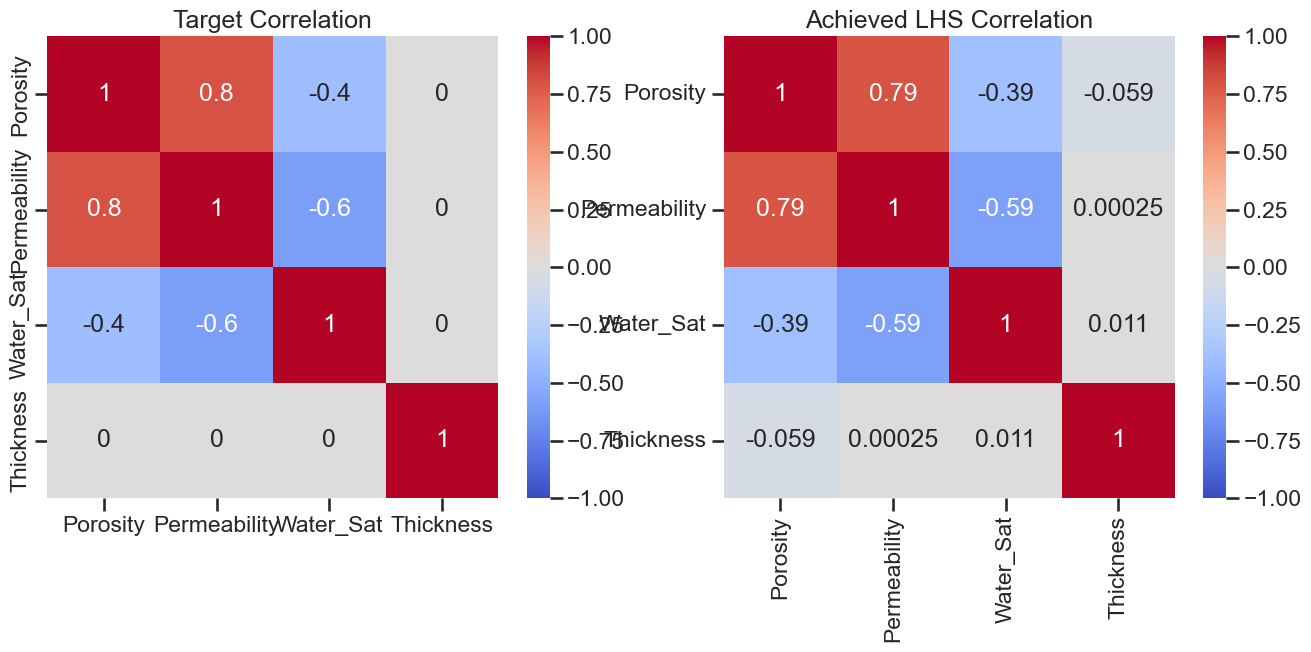

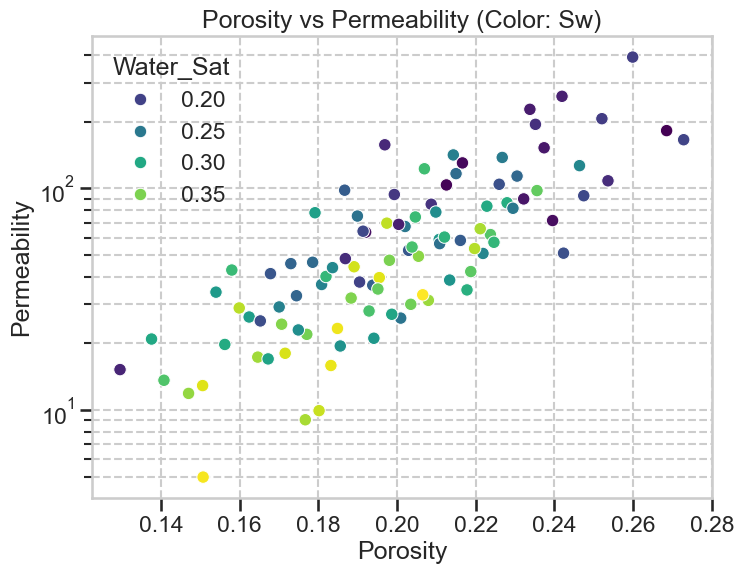

In [5]:
# Calculate Spearman Rank Correlation of the output
output_corr = df_design.corr(method='spearman')

# Plot comparison
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

sns.heatmap(target_corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1, ax=ax[0])
ax[0].set_title("Target Correlation")
ax[0].set_xticklabels(param_names)
ax[0].set_yticklabels(param_names)

sns.heatmap(output_corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1, ax=ax[1])
ax[1].set_title("Achieved LHS Correlation")

plt.show()

# Visualize Porosity vs Permeability
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_design, x='Porosity', y='Permeability', hue='Water_Sat', palette='viridis')
plt.yscale('log')
plt.title("Porosity vs Permeability (Color: Sw)")
plt.grid(True, which="both", ls="--")
plt.show()

## 6. Mock Simulation & Sensitivity Analysis
To demonstrate the value of this design, we run a "Mock Simulator." 
We calculate **Volumetric Oil In Place (STOIIP)** as a proxy for complexity.

$$STOIIP \propto A \cdot h \cdot \phi \cdot (1 - S_w)$$

*Note: In a real workflow, this step would be replaced by calling the Eclipse/tNavigator executable.*

In [6]:
# Mock "Black Box" Function
def simulator_proxy(row):
    # Area is constant for this exercise, say 100 acres
    Area = 100 * 43560 # sq ft
    h = row['Thickness']
    phi = row['Porosity']
    sw = row['Water_Sat']
    boi = 1.2 # FVF
    
    # STOIIP calculation
    stoiip = (Area * h * phi * (1 - sw)) / boi
    
    # Add some non-linearity/noise related to Perm (e.g. recovery factor proxy)
    # Higher perm = slightly higher "Recoverable" proxy
    rf = 0.2 + 0.05 * np.log10(row['Permeability'])
    
    return stoiip * rf # Returning Recoverable Reserves

# Run Simulation
df_design['Recoverable_Reserves'] = df_design.apply(simulator_proxy, axis=1)

print("Simulation complete. Results added to table.")
display(df_design.head())

Simulation complete. Results added to table.


,Porosity,Permeability,Water_Sat,Thickness,Recoverable_Reserves
0,0.156225,19.776359,0.302681,138.386714,1.449150e+07
1,0.202942,52.571147,0.218703,109.540771,1.803404e+07
2,0.188337,32.021901,0.351584,105.518696,1.287618e+07
3,0.179153,77.665897,0.290764,95.335901,1.295032e+07
4,0.227974,86.131413,0.306023,120.672229,2.056589e+07


## 7. Tornado Plot (Feature Importance)
Finally, we analyze the results. We use a linear regression on the standardized data to determine which parameter has the highest impact on Reserves.

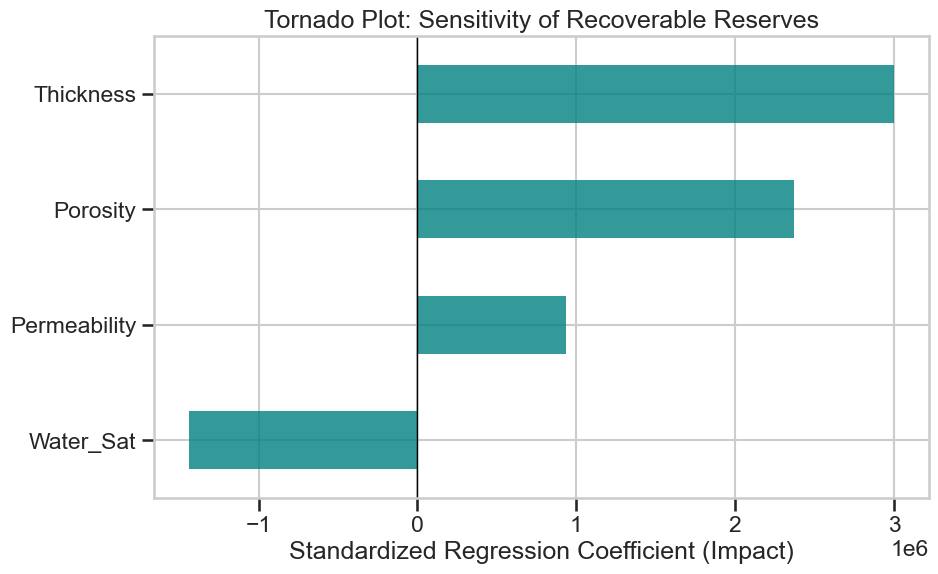

In [7]:
# Standardize data to get normalized coefficients (Beta values)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_design[param_names])
y = df_design['Recoverable_Reserves']

# Fit Proxy Model
model = LinearRegression()
model.fit(X_scaled, y)

# Extract Coefficients
coeffs = pd.Series(model.coef_, index=param_names)

# Plot Tornado
plt.figure(figsize=(10, 6))
coeffs.sort_values().plot(kind='barh', color='teal', alpha=0.8)
plt.axvline(0, color='black', linewidth=1)
plt.title("Tornado Plot: Sensitivity of Recoverable Reserves")
plt.xlabel("Standardized Regression Coefficient (Impact)")
plt.show()

## 8. Export for Reservoir Simulator
Save the design table to drive the actual simulator.

In [8]:
df_design.to_csv('reservoir_doe_table.csv', index_label='Run_ID')
print("Design table exported successfully.")

Design table exported successfully.
